#### Covid-19 detection using CNN and transfer-learning techniques on Chest X-Ray Images. 

**Research question**

Which Convolutional Neural Network (CNN) architecture for Machine Learning is the most efficient at 
classifying Chest X-Ray images for Covid-19 patients?

### 1. Libraries import and setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Model

import constants as CONSTANTS
import utilities as UTILS
from enums import (
  ClassificationType,
  CollectionType,
  LabelType,
  ModelType
)
import models as MODELS

UTILS.detect_GPU()

%load_ext tensorboard
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

✅ GPU detected


In [2]:
# Run options
SKIP_ANALYSIS = True
SKIP_MEMORY_CLEANUP = False
SKIP_MODEL_TRAINING = False
SKIP_MODEL_LOADING = not SKIP_MODEL_TRAINING
SKIP_CUSTOM_ACCURACY = False
SKIP_CONFUSSION_MATRIX = False

EPOCHS = 20
ENABLE_EARLY_STOP = False
ENABLE_TRAIN_LOGS = False
SAVE_TRAINED_MODEL = False
SELECTED_MODEL = ModelType.DEEP_COVID

### 2. Loading dataset/s

In [3]:
def loadRadiographyDataDictionary():
  def _getFolderName(labelType):
    return {
      LabelType.COVID: "COVID",
      LabelType.NORMAL: "Normal",
      LabelType.PNEUMONIA: "Viral Pneumonia"
    }[labelType]

  def _toModel(labelType):
    metadata = pd.read_excel(CONSTANTS.DATASET_RADIOGRAPHY_ROOT + "/" + _getFolderName(labelType) + ".metadata.xlsx")
    images = []

    for i in range(metadata.shape[0]):
      images.append(CONSTANTS.DATASET_RADIOGRAPHY_ROOT + "/" + _getFolderName(labelType) + "/" + metadata["FILE NAME"].iloc[i] + ".png")

    df_result = pd.DataFrame(images, columns=["image"])

    # 2 class validation override
    if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.TWO_CLASS and labelType == LabelType.PNEUMONIA:
      df_result["label"] = LabelType.COVID.value
    else:
      df_result["label"] = labelType.value

    return df_result

  return {
    LabelType.COVID: _toModel(LabelType.COVID),
    LabelType.NORMAL: _toModel(LabelType.NORMAL),
    LabelType.PNEUMONIA: _toModel(LabelType.PNEUMONIA)
  }

# radiography_data_dict = loadRadiographyDataDictionary()
# radiography_df = flatten_dataframes_dictionary(radiography_data_dict)

In [4]:
def loadChestDataDictionary():
  def _getFolderName(labelType):
    return {
      LabelType.COVID: "COVID19",
      LabelType.NORMAL: "NORMAL",
      LabelType.PNEUMONIA: "PNEUMONIA"
    }[labelType]

  def _toModel(labelType):
    images = []

    def _loadCollectionProcedure(collectionType):
      for dirname, _, filenames in os.walk(CONSTANTS.DATASET_CHEST_ROOT + "/" + collectionType.value + "/" + _getFolderName(labelType)):
        for filename in filenames:
          images.append(os.path.join(dirname, filename))

    _loadCollectionProcedure(CollectionType.TEST)
    _loadCollectionProcedure(CollectionType.TRAIN)

    df_result = pd.DataFrame(images, columns=["image"])
    
    # 2 class validation override
    if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.TWO_CLASS and labelType == LabelType.PNEUMONIA:
      df_result["label"] = LabelType.COVID.value
    else:
      df_result["label"] = labelType.value

    return df_result

  return {
    LabelType.COVID: _toModel(LabelType.COVID),
    LabelType.NORMAL: _toModel(LabelType.NORMAL),
    LabelType.PNEUMONIA: _toModel(LabelType.PNEUMONIA)
  }

# chest_data_dict = loadChestDataDictionary()
# chest_df = flatten_dataframes_dictionary(chest_data_dict)

In [5]:
chest_data_dict = loadChestDataDictionary()
chest_df = UTILS.flatten_dataframes_dictionary(chest_data_dict)
# del chest_data_dict, chest_df

print("Chest dataset:")
print(chest_df["label"].value_counts())

Chest dataset:
pneumonia    4273
normal       1583
covid         576
Name: label, dtype: int64


In [6]:
radiography_data_dict = loadRadiographyDataDictionary()
radiography_df = UTILS.flatten_dataframes_dictionary(radiography_data_dict)

print("Radiography dataset:")
print(radiography_df["label"].value_counts())

Radiography dataset:
normal       10192
covid         3616
pneumonia     1345
Name: label, dtype: int64


In [7]:
if not SKIP_ANALYSIS:
  unbalanced_source_dict = UTILS.merge_dataframe_dictionaries(chest_data_dict, radiography_data_dict)
  unbalanced_data_df = UTILS.flatten_dataframes_dictionary(unbalanced_source_dict)

# Balance data labels
source_dict = UTILS.merge_dataframe_dictionaries(chest_data_dict, radiography_data_dict)
UTILS.min_count_balance_data_dict(source_dict)

source_df = UTILS.flatten_dataframes_dictionary(source_dict)

print("Source dataset:")
print(source_df["label"].value_counts())

Source dataset:
pneumonia    4192
normal       4192
covid        4192
Name: label, dtype: int64


### 3. Dataset analysis

In [8]:
if not SKIP_ANALYSIS:
  sns.countplot(data=unbalanced_data_df, x="label", order=unbalanced_data_df.label.value_counts().index)
  del unbalanced_source_dict, unbalanced_data_df

In [9]:
if not SKIP_ANALYSIS:
  sns.countplot(data=source_df, x="label", order=source_df.label.value_counts().index)

In [10]:
if not SKIP_ANALYSIS:
    def plot_3_samples(labelType):
        image_samples = list(source_dict[labelType].sample(3)["image"]) 
        plt.figure(figsize=(10, 10))

        for i, sample in zip(range(3), image_samples):
            plt.subplot(3, 3, i + 1)
            img = plt.imread(sample)
            plt.imshow(img, cmap="gray")
            plt.title(labelType.value.upper())
            plt.axis("off")
            
        plt.tight_layout()
    
    plot_3_samples(LabelType.COVID)
    plot_3_samples(LabelType.NORMAL)

    if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.THREE_CLASS:
        plot_3_samples(LabelType.PNEUMONIA)

In [11]:
if not SKIP_ANALYSIS:
  sample_img = plt.imread(list(source_df.sample(1)["image"])[0])
  plt.imshow(sample_img, cmap="gray")
  plt.colorbar()
  plt.title("Raw Chest X Ray Image")

  print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
  print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
  print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

In [12]:
def plot_dist_for_image(image_array):
  sns.distplot(image_array,
    label=f"Pixel Mean {np.mean(image_array):.4f} & Standard Deviation {np.std(image_array):.4f}", 
    kde=False)
  plt.legend(loc="upper right")
  plt.title("Distribution of Pixel Intensities in the Image")
  plt.xlabel("Pixel Intensity")
  plt.ylabel("# Pixels in Image")

if not SKIP_ANALYSIS:
  plot_dist_for_image(sample_img)

Average pixel distribution from random sample collection

In [13]:
if not SKIP_ANALYSIS:
  average_image = np.mean([img_to_array(load_img(path, target_size=CONSTANTS.INPUT_SIZE)) for path in chest_df.sample(200)["image"]], axis=1)
  plot_dist_for_image(average_image)

In [14]:
if not SKIP_ANALYSIS:
  average_image = np.mean([img_to_array(load_img(path, target_size=CONSTANTS.INPUT_SIZE)) for path in radiography_df.sample(200)["image"]], axis=1)
  plot_dist_for_image(average_image)

### 4. Model building

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
  source_df["image"],
  source_df["label"],
  test_size=CONSTANTS.TEST_SPLIT_SIZE,
  random_state=42
)

train_df = pd.DataFrame({ "image_path": x_train, "label": y_train })
test_df = pd.DataFrame({ "image_path": x_test, "label": y_test })

In [16]:
class_mode = "sparse" if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.THREE_CLASS else "binary"

train_generator = ImageDataGenerator(CONSTANTS.TRAIN_IMAGE_GEN_OPTIONS).flow_from_dataframe(
  train_df,
  x_col="image_path",
  y_col="label",
  target_size=CONSTANTS.INPUT_SIZE,
  batch_size=48,
  shuffle=True,
  class_mode=class_mode,
  validate_filenames=True
)

test_generator = ImageDataGenerator(CONSTANTS.TEST_IMAGE_GEN_OPTIONS).flow_from_dataframe(
  test_df,
  x_col="image_path",
  y_col="label",
  target_size=CONSTANTS.INPUT_SIZE,
  batch_size=32,
  shuffle=False,
  class_mode=class_mode,
  validate_filenames=True
)

Found 10060 validated image filenames belonging to 3 classes.
Found 2516 validated image filenames belonging to 3 classes.


🌊🌊🌊🌊🌊🌊🌊 **Run above for data preparation** 🌊🌊🌊🌊🌊🌊🌊

In [17]:
if not SKIP_MEMORY_CLEANUP:
  try:
    del chest_data_dict, chest_df
  except:
    print("Chest dataset not found")

  try:
    del radiography_data_dict, radiography_df
  except:
    print("Radiography dataset not found")

  try:
    del source_dict
  except:
    print("Source dataset not found")

##### Train or load saved model

- [RAM optimisation stack overflow](https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch)

🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧

In [18]:
# import tensorflow as tf
# tf.keras.mixed_precision.set_global_policy("mixed_float16")

# WARNING:tensorflow:Mixed precision compatibility check (mixed_float16): WARNING
# Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
#   NVIDIA GeForce GTX 1060, compute capability 6.1
# See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
# If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once

In [19]:
# Train selected model or try to load saved weights
if not SKIP_MODEL_TRAINING:
  model = MODELS.get(SELECTED_MODEL)
elif not SKIP_MODEL_LOADING:
  model = UTILS.load_my_model(SELECTED_MODEL, CONSTANTS.CLASSIFICATION_MODE)
else:
  print("🚒🔥 configuration error, no model was not loaded 🚒🔥")

In [20]:
if not SKIP_MODEL_TRAINING:  
  callbacks = []
  if ENABLE_TRAIN_LOGS:
    callbacks.append(UTILS.get_tensorboard_callback(SELECTED_MODEL))
  else:
    print("❗ Warning. Training will not be logged ❗")
  if ENABLE_EARLY_STOP:
    callbacks.append(EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 4))

  history = model.fit(
    train_generator,
    callbacks=callbacks,
    validation_data=test_generator,
    epochs=EPOCHS,
    verbose=1
  )

❗ Warning. Training will not be logged ❗


C:\tools\python\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/2
210/210 [==============================] - 165s 770ms/step - loss: 0.6055 - accuracy: 0.7195 - val_loss: 0.4252 - val_accuracy: 0.8088
Epoch 2/2
210/210 [==============================] - 144s 684ms/step - loss: 0.3975 - accuracy: 0.8354 - val_loss: 0.3158 - val_accuracy: 0.8788


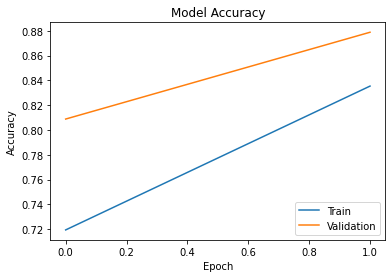

In [21]:
if not SKIP_MODEL_TRAINING:
  def plot_accuracy(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"], loc = "lower right")
    plt.show()

  plot_accuracy(history)

In [22]:
if not SKIP_MODEL_TRAINING and SAVE_TRAINED_MODEL:
  UTILS.save_my_model(model, SELECTED_MODEL, True)

🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧

### Prediction preview

random image from dataset is taken to predict label

In [23]:
def get_ready_image(image_path):
  image = load_img(image_path, target_size=CONSTANTS.INPUT_SIZE)
  return img_to_array(image).reshape(tuple([1, *CONSTANTS.INPUT_SIZE, 3])), image # (1,256,256,3)

✅


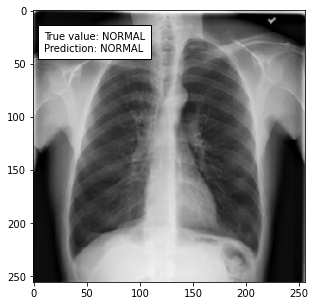

In [24]:
def preview_predict(sample, plot_img=True):
    image_path = sample["image"]
    image_label = sample["label"]
    img, image = get_ready_image(image_path)

    result = model.predict(img)
    # result = np.argmax(result, axis=-1)[0] # covid, normal, pneumonia
    if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.TWO_CLASS:
        # Binary mode
        result = np.round(result).astype(int).flatten()
    else:
        # Categorical mode
        result = np.argmax(result, axis=-1)
    prediction = LabelType.COVID if result == 0 else LabelType.NORMAL if result == 1 else LabelType.PNEUMONIA

    if (plot_img):
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.text(10, 38, f"True value: {image_label.upper()}\nPrediction: {prediction.value.upper()}", bbox={"facecolor": "white", "pad": 6})

    return image_label.upper() == prediction.value.upper()

print("✅" if preview_predict(source_df.sample(1).iloc[0]) else "❌")

In [25]:
def custom_accuracy(sample_count = 200):
  samples = source_df.sample(sample_count)
  results = np.array([preview_predict(samples.iloc[i], False) for i in range(len(samples))])
  accuracy = np.count_nonzero(results) * 100 / sample_count
  print(f"Custom accuracy from {sample_count} samples is {accuracy:.4f}")

if not SKIP_CUSTOM_ACCURACY:
  custom_accuracy()

Custom accuracy from 200 samples is 88.0000


### Confusion matrix

Model sensitivity 87.4696
Model specificity 91.9126


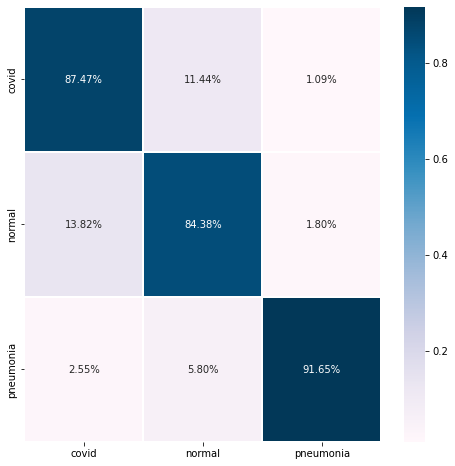

In [26]:
def my_confussion_matrix(a_model, in_percent = True, generator = test_generator):
    class_names = [e.value for e in LabelType]

    if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.TWO_CLASS:
        class_names.remove(LabelType.PNEUMONIA.value)

    predictions = a_model.predict(generator)

    if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.TWO_CLASS:
        # Binary mode
        predictions = np.round(predictions).astype(int).flatten()
    else:
        # Categorical mode
        predictions = np.argmax(predictions, axis=1)

    cm = confusion_matrix(generator.classes, predictions, normalize="true" if in_percent else "false")
    cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    
    plt.figure(figsize = (8, 8))
    sns.heatmap(
        cm, cmap = "PuBu", linecolor = "white", 
        linewidth = 2, annot = True, fmt = ".2%" if in_percent else "d",
        xticklabels = class_names, yticklabels = class_names)

    return confusion_matrix(generator.classes, predictions)

if True or not SKIP_CONFUSSION_MATRIX:
    cm = my_confussion_matrix(model)

    if CONSTANTS.CLASSIFICATION_MODE == ClassificationType.THREE_CLASS:
        print(f"Model sensitivity %.4f" % (UTILS.categorical_covid_sensitivity(cm) * 100))
        print(f"Model specificity %.4f" % (UTILS.categorical_covid_specificity(cm) * 100))

### One time runs

In [27]:
def _plot_feature_map(features):
  plt.figure(figsize=(30, 30))
  for i in range(1, features.shape[3] + 1):
    row_count = int(np.ceil(features.shape[3] / 8))
    plt.subplot(8, row_count, i)
    plt.axis("off")
    plt.imshow(features[0,:,:,i-1] , cmap="gray")

def visualize_feature_maps(base_model, sample):
  for i in range(min(len(base_model.layers), 2)):
    layer = base_model.layers[i]
    if "conv" not in layer.name:
      continue

    print(layer.name)
    iModel = Model(inputs=base_model.inputs, outputs=layer.output)
    img, _ = get_ready_image(sample["image"])
    print("Visualizing feature map for:", sample["label"].upper())

    _plot_feature_map(iModel.predict(img))
    plt.show()

# visualize_feature_maps(model, source_df.sample(1, random_state=42).iloc[0])
# visualize_feature_maps(model, source_df.sample(1, random_state=43).iloc[0])